# Titanic Survival Prediction Dataset
### Zofia Piesik, 278850

"What sorts of people were more likely to survive?"


## 0. Libraries and requirements

In [ ]:
# Install requirements
%pip install -r requirements.txt

In [907]:
# Imports
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, sigmoid, tanh
from keras.utils import plot_model

import matplotlib.pyplot as plt
plt.style.use("default")

In [908]:
# Data frame to collect scores for summary.
df_summary = pd.DataFrame({"Classifier": [], "First Dataset": [], "Second Dataset": []})

In [909]:
# Add to summary table function
def add_to_summary(title, score1, score2, df_summary=df_summary):
    df_summary.loc[len(df_summary)] = [title,  score1, score2]

## 1. Check dataset

### Data values

|Variable |	Definition |	Key|
|---------|-------------|------|
|Survival|    	Is survival|	0 = No, 1 = Yes|
|Pclass	|Class| class	1 = 1st, 2 = 2nd, 3 = 3rd|
|Sex	|Sex| male/female|
|Age	|Age in years	||
|SibSp	|Number of siblings / spouses aboard the Titanic	||
|Parch	|Number of parents / children aboard the Titanic	||
|Ticket	|Ticket number	|letter+number or number|
|Fare|	Passenger fare	|decimal |
|Cabin|	Cabin number	|letters+number|
|Embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

### Variable Notes
**pclass:** 
A proxy for socio-economic status (SES) \
1st = Upper \
2nd = Middle \
3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way... \
Sibling = brother, sister, stepbrother, stepsister \
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way... \
Parent = mother, father \
Child = daughter, son, stepdaughter, stepson\
Some children travelled only with a nanny, therefore parch=0 for them.

In [910]:
# Convert data from csv to dataset
df = pd.read_csv("Titanic-Dataset.csv").set_index("PassengerId")
df


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [911]:
# Check values in columns
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
df.info()

Number of rows:  891
Number of columns:  11
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Output above shows that in dataset are 11 columns and 891 rows, also "Age" and "Cabin" may have "null" values.
"Cabin" column doesn't have values for less than 25% of rows, that's why it can be deleted. There are also unique text values like "Name" that can be deleted. For neural network better leave only numerical data. "Ticket" are usually the same for families, but we already has information about family, so it will be also deleted.

In [912]:
print(df['Name'].nunique())
print(df['Ticket'].nunique())

# Remove "Cabin", "Name", "Ticket"
df = df.drop(["Cabin","Name","Ticket"], axis=1)

# Change "Embarked" and "Sex" to numbers

embarked = {"C":1, "Q": 2, "S": 3}
df['Embarked'] = df['Embarked'].map(embarked)

sex = {"male": 1, "female": 2}
df['Sex'] = df['Sex'].map(sex)
df

891
681


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3.0
2,1,1,2,38.0,1,0,71.2833,1.0
3,1,3,2,26.0,0,0,7.9250,3.0
4,1,1,2,35.0,1,0,53.1000,3.0
5,0,3,1,35.0,0,0,8.0500,3.0
...,...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,13.0000,3.0
888,1,1,2,19.0,0,0,30.0000,3.0
889,0,3,2,NaN,1,2,23.4500,3.0


Now table has 8 numerical columns. In "Age" and "Embarked" still have "NaN" values.

In [913]:
print("Missing age: ", df.query('Age.isnull()').shape[0])
print("Missing embarked: ",df.query('Embarked.isnull()').shape[0])

Missing age:  177
Missing embarked:  2


177 rows - it lots of data. Instead of deleting it is possible to put "fake" data by the "k nearest neighbours". 

In [914]:
from sklearn.impute import KNNImputer

# I specify the nearest neighbor to be 3 
transformer = KNNImputer(n_neighbors=3)
age = transformer.fit_transform(df[["Age"]])
embarked = transformer.fit_transform(df[["Embarked"]])
df["Age"] = age.round(2)
df["Embarked"] = embarked.round(2)

print("Missing age: ", df.query('Age.isnull()').shape[0])
print("Missing embarked: ",df.query('Embarked.isnull()').shape[0])

df

Missing age:  0
Missing embarked:  0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3.0
2,1,1,2,38.0,1,0,71.2833,1.0
3,1,3,2,26.0,0,0,7.9250,3.0
4,1,1,2,35.0,1,0,53.1000,3.0
5,0,3,1,35.0,0,0,8.0500,3.0
...,...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,13.0000,3.0
888,1,1,2,19.0,0,0,30.0000,3.0
889,0,3,2,29.7,1,2,23.4500,3.0


## 2. Optimization

### Balancing data
We have to check if survived and no survived are equal or almost equal.

Survived
0    549
1    342
dtype: int64

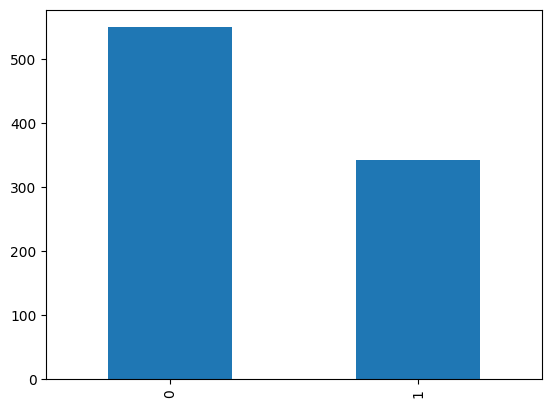

In [915]:
# Check if amount of survived and no survived 
df['Survived'].value_counts().plot.bar()
df.value_counts('Survived')


There is more not Survived. We can duplicate some "Survivors" to equalise the amount of data.

Survived diffrence:  207
Rows to add (shape):  (207, 8)
New shape:  (1098, 8)


<AxesSubplot:>

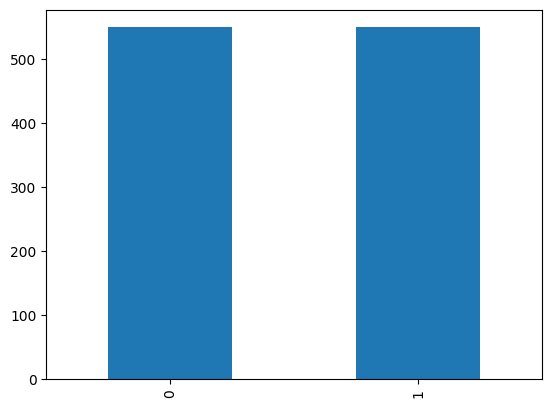

In [916]:
survived_diff=df.shape[0]-df["Survived"].sum()*2
print("Survived diffrence: ",survived_diff)

# Get n(survived_diff) survivors rows
new_rows = df.query('Survived == 1').sample(survived_diff)
print("Rows to add (shape): ", new_rows.shape)

# Add n(survived_diff) survivors rows to dataset
df = pd.concat([df, new_rows])
print("New shape: ", df.shape)

df['Survived'].value_counts().plot.bar()

## 3. More data
Dataset is still small. We can duplicate it several times.

In [917]:
for i in range(3):
    df = pd.concat([df,df])
df = df.reset_index(drop=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,3.0
1,1,1,2,38.0,1,0,71.2833,1.0
2,1,3,2,26.0,0,0,7.9250,3.0
3,1,1,2,35.0,1,0,53.1000,3.0
4,0,3,1,35.0,0,0,8.0500,3.0
...,...,...,...,...,...,...,...,...
8779,1,2,2,19.0,0,0,26.0000,3.0
8780,1,1,2,30.0,0,0,31.0000,1.0
8781,1,3,2,19.0,0,0,7.8792,2.0
8782,1,1,2,17.0,1,0,57.0000,3.0


Now dataset has 8784 rows and 8 columns.

## 4. Two data versions

**First dataset** - without changes

**Second dataset** - PCA + min-max scaling


In [918]:
first_df = df
first_inputs = df.values[:, 1:]
first_classes = df.values[:, 0]

(train_inputs_1, test_inputs_1, train_labels_1, test_labels_1) = train_test_split(first_inputs, first_classes, train_size=0.75, random_state=278850)

In [919]:
survived_col = df['Survived']
second_df = df.drop(['Survived'], axis=1)

sec_inputs = df.values[:, 1:]
sec_classes = df.values[:, 0]

# min-max scaling
sec_inputs = (sec_inputs-sec_inputs.min())/(sec_inputs.max()-sec_inputs.min())
print(sec_inputs)


[[0.00585561 0.00195187 0.04294114 ... 0.         0.01415106 0.00585561]
 [0.00195187 0.00390374 0.07417106 ... 0.         0.13913574 0.00195187]
 [0.00585561 0.00390374 0.05074862 ... 0.         0.01546857 0.00585561]
 ...
 [0.00585561 0.00390374 0.03708553 ... 0.         0.01537917 0.00390374]
 [0.00195187 0.00390374 0.03318179 ... 0.         0.11125659 0.00585561]
 [0.00585561 0.00195187 0.05797054 ... 0.         0.01512699 0.00390374]]


In [920]:
pca= PCA(n_components=sec_inputs.shape[1])
sec_inputs = pca.fit_transform(sec_inputs)
explained_variance=pca.explained_variance_ratio_
print(explained_variance)

[9.42372512e-01 5.66521595e-02 3.88330084e-04 2.07615569e-04
 1.60589906e-04 1.48291792e-04 7.05014172e-05]


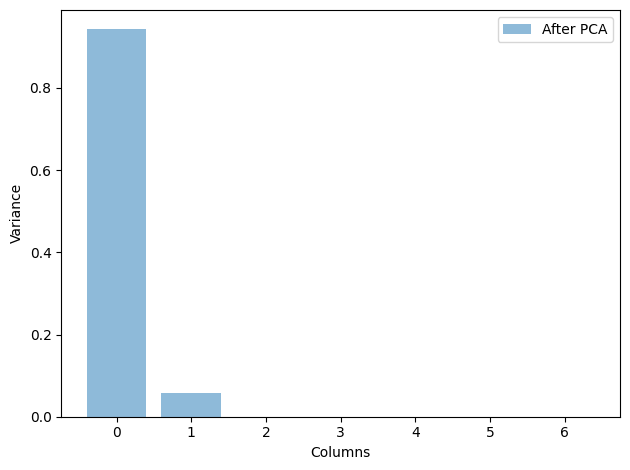

In [921]:
plt.bar(range(sec_inputs.shape[1]), explained_variance, alpha=0.5, align='center', label="After PCA")
plt.ylabel('Variance')
plt.xlabel('Columns')
plt.legend(loc='best')
plt.tight_layout()

[0.94237251 0.05665216]


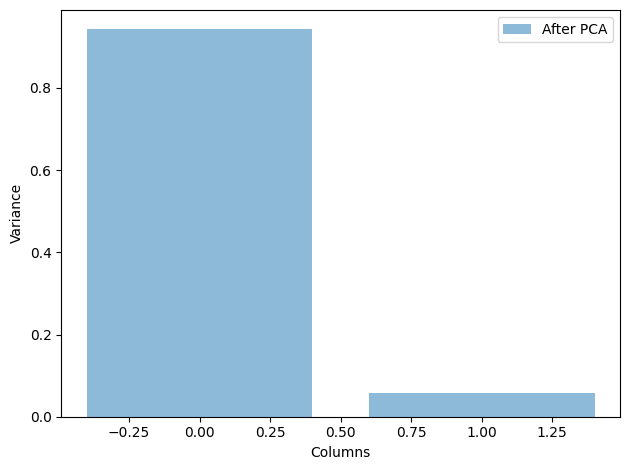

In [922]:
pca=PCA(n_components=2)

sec_inputs=pca.fit_transform(sec_inputs)

explained_variance=pca.explained_variance_ratio_
print(explained_variance)

plt.bar(range(sec_inputs.shape[1]), explained_variance, alpha=0.5, align='center', label="After PCA")
plt.ylabel('Variance')
plt.xlabel('Columns')
plt.legend(loc='best')
plt.tight_layout()


(train_inputs_2, test_inputs_2, train_labels_2, test_labels_2) = train_test_split(sec_inputs, sec_classes, train_size=0.75, random_state=278850)

In [923]:
print(train_inputs_1.shape)
print(train_inputs_2.shape)

(6588, 7)
(6588, 2)


## 5. Decision tree

In [924]:
def decision_tree(train_inputs,train_labels,test_inputs, test_labels, max_depth=None):
    dtc = DecisionTreeClassifier(random_state=278850, max_depth=max_depth)
    dtc.fit(train_inputs,train_labels)
    plot_tree(dtc)

    score = round(dtc.score(test_inputs, test_labels)*100, 2)
    print(f"Score: {score}%")

    test_pred = dtc.predict(test_inputs)
    cm = confusion_matrix(test_labels, test_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
    display.plot()
    
    return score

### 5.1.1 All nodes - first dataset

Score: 97.95%


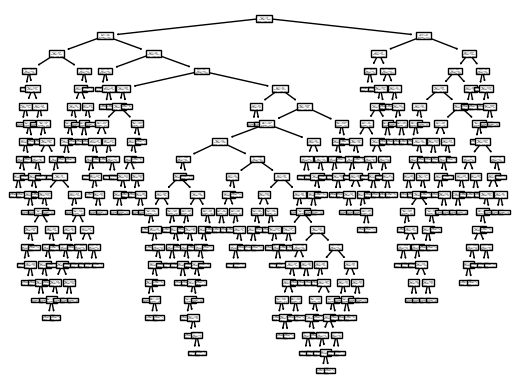

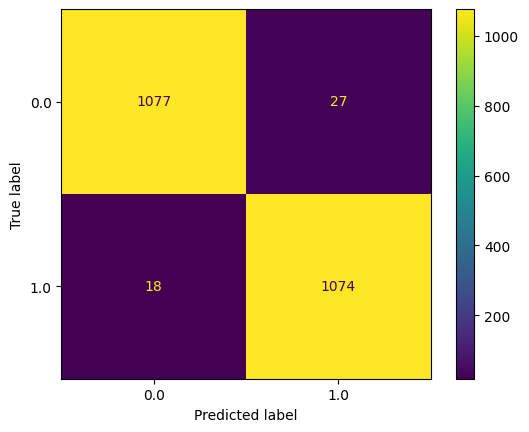

In [925]:
score1 = decision_tree(train_inputs_1, train_labels_1,test_inputs_1,test_labels_1)


### 5.1.2 All nodes - Second dataset

Score: 97.95%


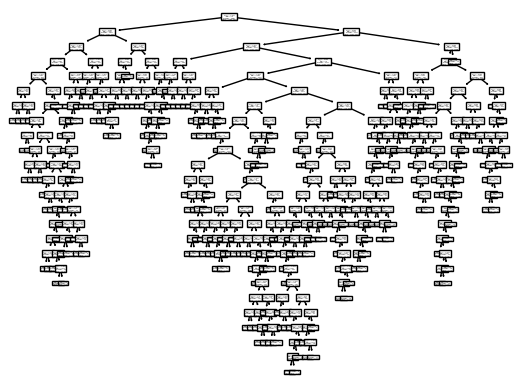

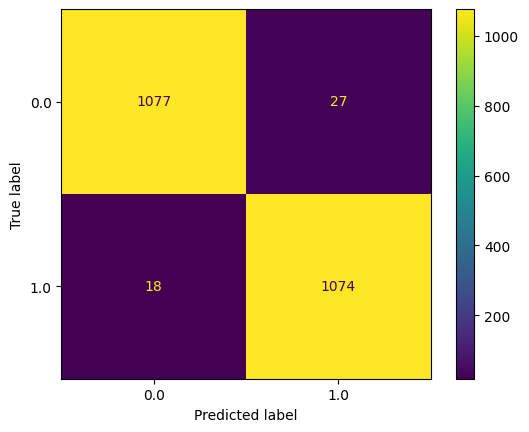

In [926]:
score2 = decision_tree(train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

In [927]:
add_to_summary("Decision Tree: All nodes", score1, score2)

### 5.2.1 8-layers - first dataset

Score: 88.52%


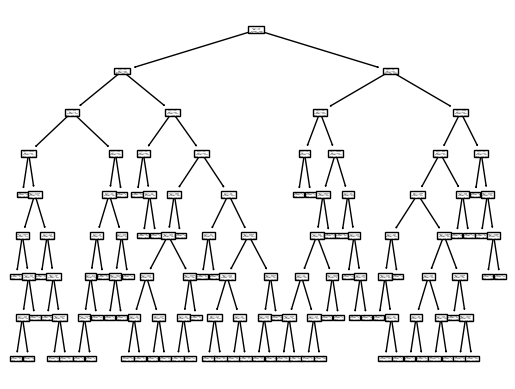

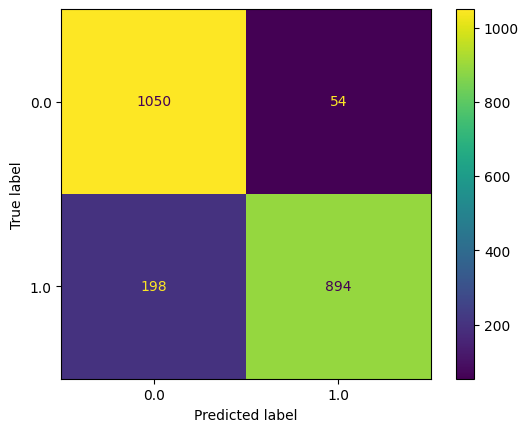

In [928]:
score1 = decision_tree(train_inputs_1, train_labels_1,test_inputs_1,test_labels_1, 8)

After leave only 8 layers of decision tree first dataset still has more than 85% of correctness.

### 5.2.2 8-layers - second dataset

Score: 78.37%


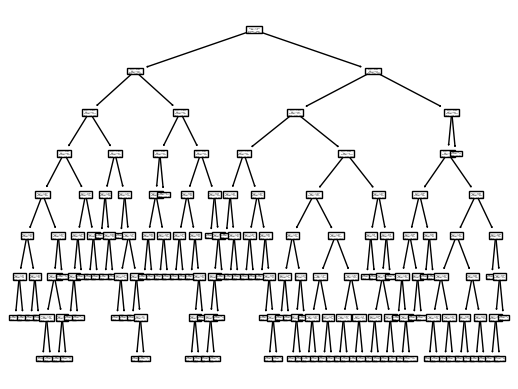

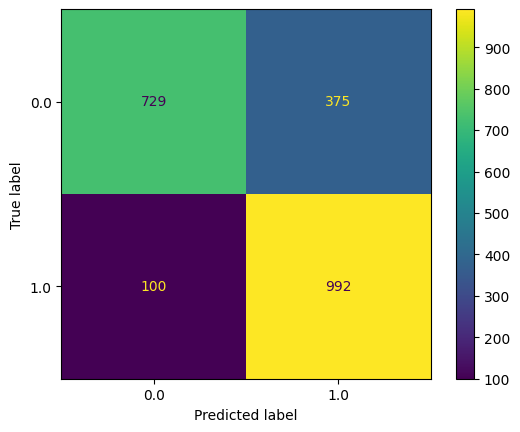

In [929]:
score2 = decision_tree(train_inputs_2, train_labels_2,test_inputs_2,test_labels_2, 8)


In [930]:
add_to_summary("Decision Tree: 8 nodes", score1, score2)

## 6. Naive Bayes

In [931]:
def naive_bayes(train_inputs,train_labels,test_inputs, test_labels):
    nb = GaussianNB()
    nb.fit(train_inputs, train_labels)
    pred = nb.predict(test_inputs)
    score = round(nb.score(test_inputs, test_labels)*100,2)
    print(f"Score: {score}%")

    cm = confusion_matrix(test_labels, pred, labels=nb.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
    display.plot()
    
    return score

### 6.1 Naive Bayes - first dataset

Score: 76.64%


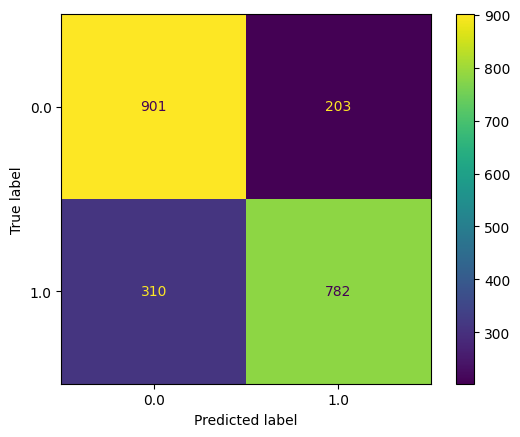

In [932]:
score1 = naive_bayes(train_inputs_1, train_labels_1,test_inputs_1,test_labels_1)


### 6.2 Naive Bayes - Second dataset

Score: 58.2%


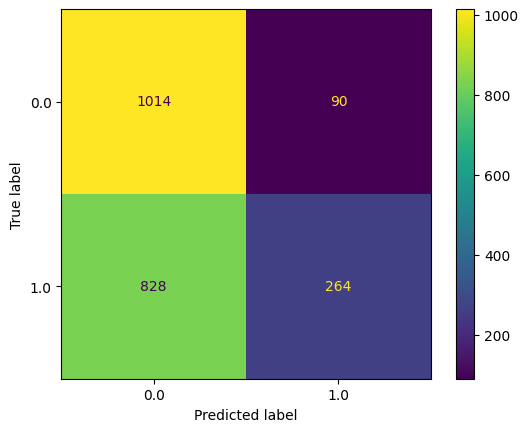

In [933]:
score2 = naive_bayes(train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

In [934]:
add_to_summary("Naive Bayes", score1, score2)

## 7. K Nearest Neighbours

In [935]:
def k_nearest_neighbours(k, train_inputs, train_labels,test_inputs,test_labels):
    knc = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knc.fit(train_inputs, train_labels)
    pred = knc.predict(test_inputs)
    score = round(knc.score(test_inputs, test_labels)*100,2)
    print(f"Score: {score}%")

    cm = confusion_matrix(test_labels, pred, labels=knc.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knc.classes_)
    display.plot()
    return score

## 7.1.1. First Dataset - 3 Nearest Neighbours

Score: 97.86%


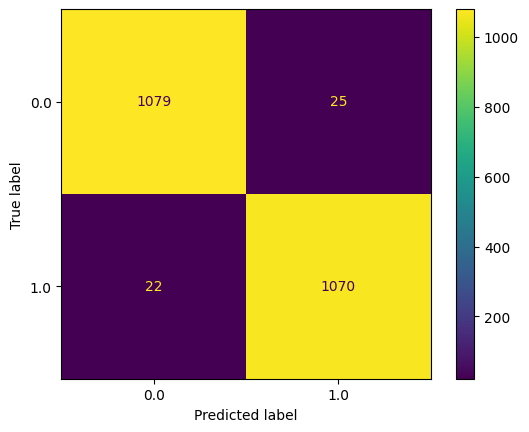

In [936]:
score1 = k_nearest_neighbours(3, train_inputs_1, train_labels_1,test_inputs_1,test_labels_1)

## 7.1.2 Second Dataset - 3 Nearest Neighbours

Score: 97.4%


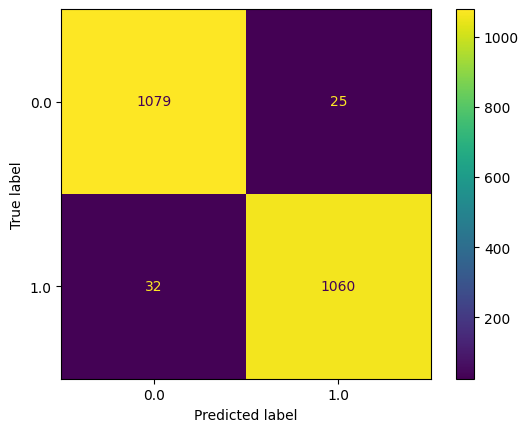

In [937]:
score2 = k_nearest_neighbours(3, train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

In [938]:
add_to_summary("3 Nearest Neighbours", score1, score2)

## 7.2.1 First Dataset - 10 Nearest Neighbours

Score: 93.03%


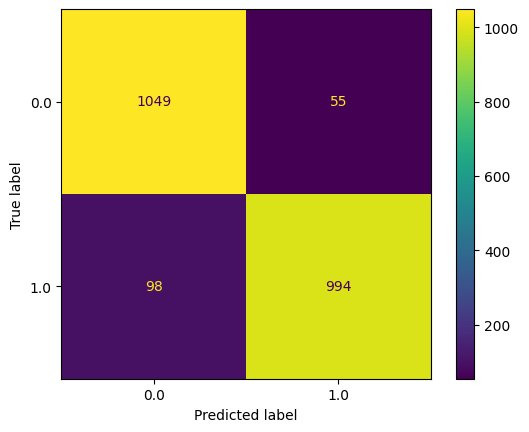

In [939]:
score1 = k_nearest_neighbours(10, train_inputs_1, train_labels_1,test_inputs_1,test_labels_1)

## 7.2.2 Second Dataset - 10 Nearest Neighbours

Score: 92.67%


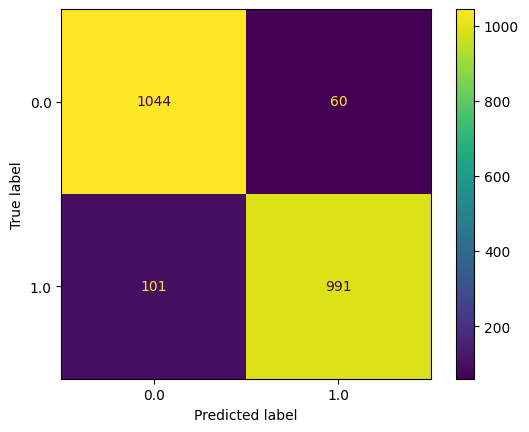

In [940]:
score2 = k_nearest_neighbours(10, train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

In [941]:
add_to_summary("10 Nearest Neighbours", score1, score2)

## 7.3.1. First Dataset - 25 Nearest Neighbours

Score: 80.83%


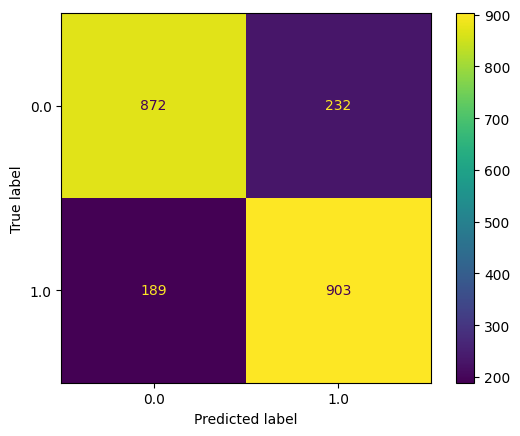

In [942]:
score1 = k_nearest_neighbours(25, train_inputs_1, train_labels_1,test_inputs_1,test_labels_1)

## 7.3.2 Second Dataset - 25 Nearest Neighbours

Score: 80.83%


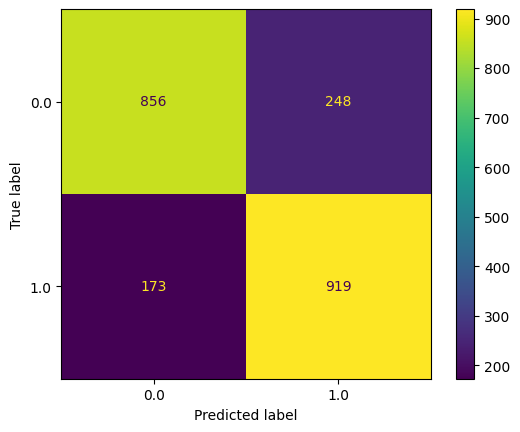

In [943]:
score2 = k_nearest_neighbours(25, train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

In [944]:
add_to_summary("25 Nearest Neighbours", score1, score2)

## 8. Neural Networks

In [945]:
# Function to plot loss curve

def loss_curve(history, title='Loss Curve'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Test')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [946]:
# Function to create neural network

def neural_network(hidden_layers, train_inputs, train_labels, test_inputs, test_labels,epochs=400,batch_size=32):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_dim=train_inputs.shape[1]))
    for i in hidden_layers[1:-1]:
        model.add(Dense(i, activation='relu'))
    model.add(Dense(hidden_layers[-1], activation='sigmoid'))
    
    # Labels has only two classes, so "binary_crossentropy"
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    

    history = model.fit(train_inputs, train_labels, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(test_inputs, test_labels))
    pred = model.predict(test_inputs).round()
    score = round(accuracy_score(pred, test_labels), 2)* 100
    print(f"Score: {score}%")
    
    cm = confusion_matrix(test_labels,pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    display.plot()
    
    return score, history
    
        

## 8.1 Neural Network (6:3:1)

## 8.1.1 First Dataset

69/69 [==============================] - 0s 679us/step
Score: 50.0%


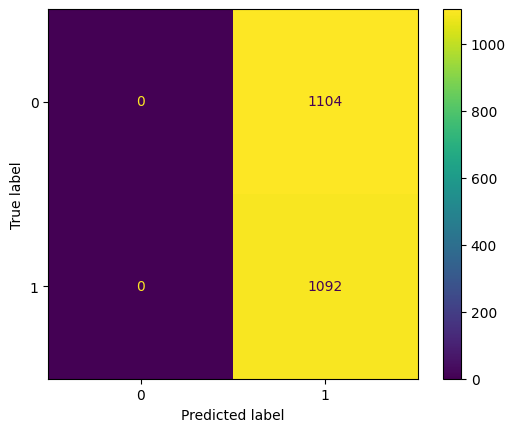

In [947]:
score1, history1 = neural_network([6,3,1], train_inputs_1, train_labels_1, test_inputs_1, test_labels_1)

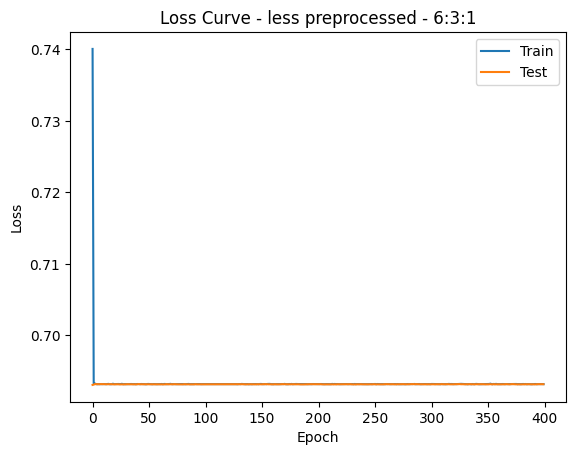

In [948]:
loss_curve(history1, 'Loss Curve - less preprocessed - 6:3:1')

## 8.1.2 Second Dataset

69/69 [==============================] - 0s 658us/step
Score: 65.0%


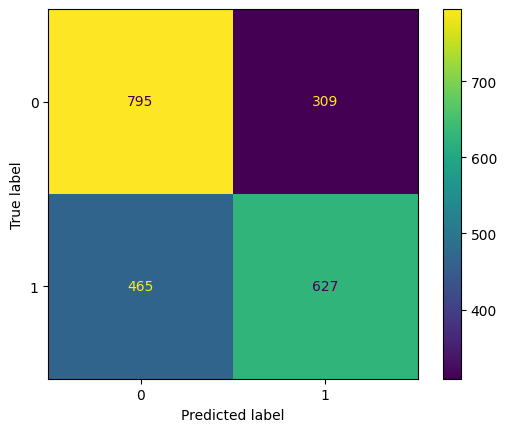

In [949]:
score2, history2 = neural_network([6,3,1], train_inputs_2, train_labels_2,test_inputs_2,test_labels_2)

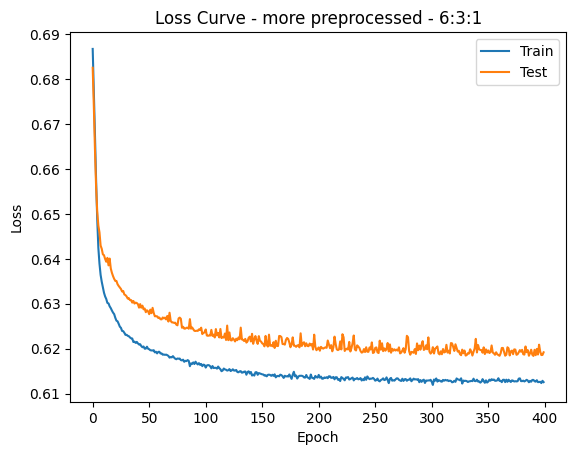

In [950]:
loss_curve(history2, 'Loss Curve - more preprocessed - 6:3:1')

In [951]:
add_to_summary("Neural Network - 6:3:1", score1, score2)

## 8.2 Neural Network (9:6:3:1)

## 8.2.1 Firts Dataset

69/69 [==============================] - 0s 791us/step
Score: 82.0%


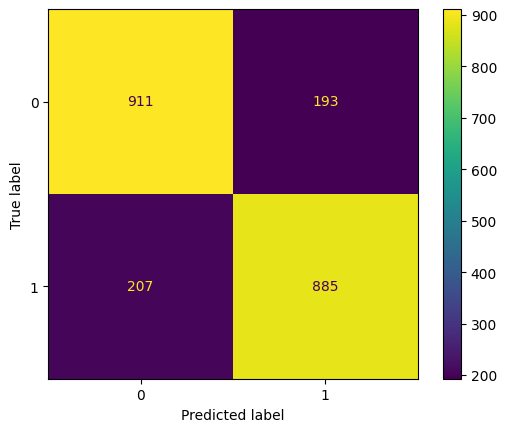

In [952]:
score1, history1 = neural_network([9,6,3,1], train_inputs_1, train_labels_1, test_inputs_1, test_labels_1)

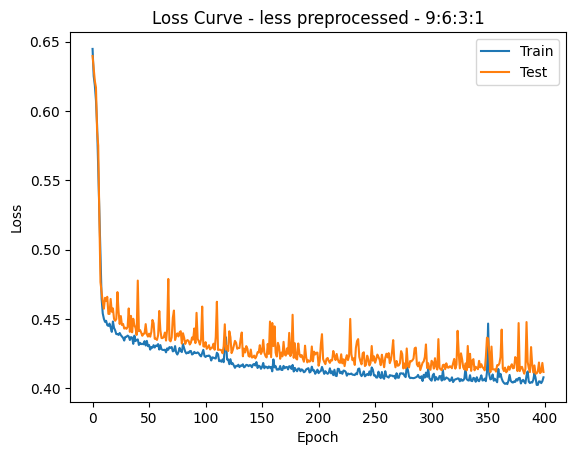

In [953]:
loss_curve(history1, 'Loss Curve - less preprocessed - 9:6:3:1')

## 8.2.2 Second Dataset

69/69 [==============================] - 0s 797us/step
Score: 50.0%


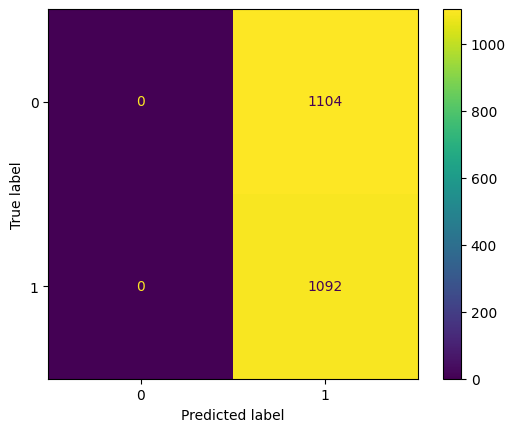

In [954]:
score2, history2 = neural_network([9,6,3,1], train_inputs_2, train_labels_2, test_inputs_2, test_labels_2)

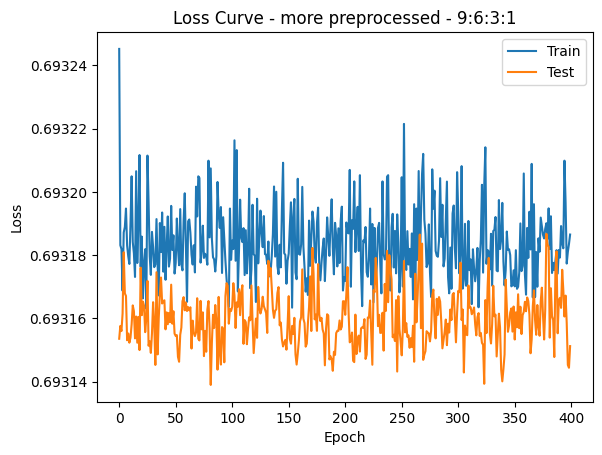

In [955]:
loss_curve(history2, 'Loss Curve - more preprocessed - 9:6:3:1')

In [956]:
add_to_summary("Neural Network - 9:6:3:1", score1, score2)

## 8.3 Neutral Network (12:9:6:3:2:1)

## 8.3.1 First Dataset

69/69 [==============================] - 0s 798us/step
Score: 84.0%


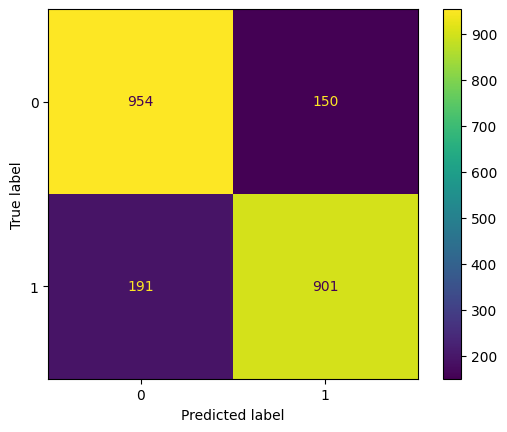

In [957]:
score1, history1 = neural_network([12,9,6,3,2,1], train_inputs_1, train_labels_1, test_inputs_1, test_labels_1)


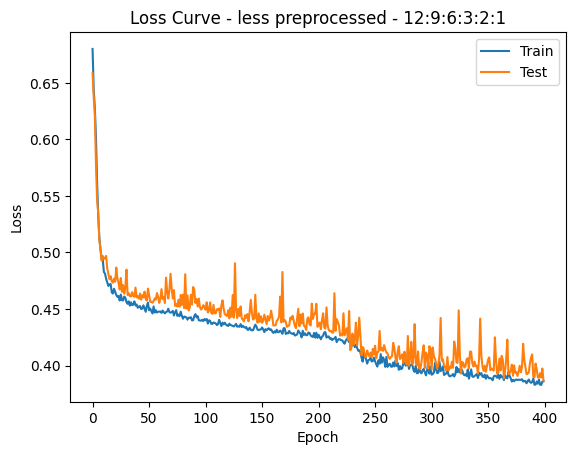

In [958]:
loss_curve(history1, 'Loss Curve - less preprocessed - 12:9:6:3:2:1')

### 8.3.2 Second dataset

69/69 [==============================] - 0s 708us/step
Score: 69.0%


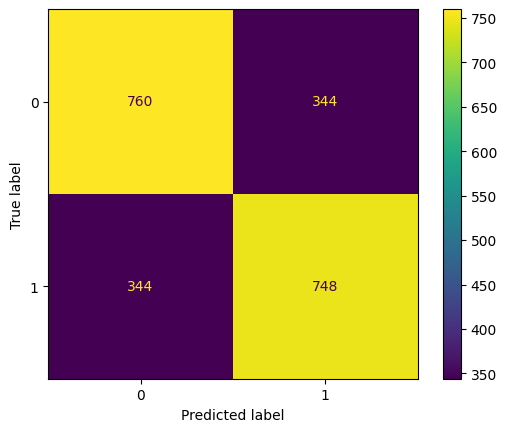

In [959]:
score2, history2 = neural_network([12,9,6,3,2,1], train_inputs_2, train_labels_2, test_inputs_2, test_labels_2)

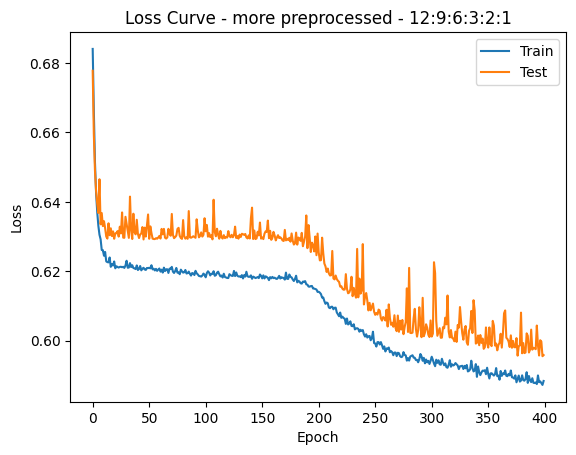

In [960]:
loss_curve(history2, 'Loss Curve - more preprocessed - 12:9:6:3:2:1')

In [961]:
add_to_summary("Neural Network - 12:9:6:3:1", score1, score2)

## 8.4 Neural Network (3:3:1)

## 8.4.1 First Dataset

69/69 [==============================] - 0s 737us/step
Score: 78.0%


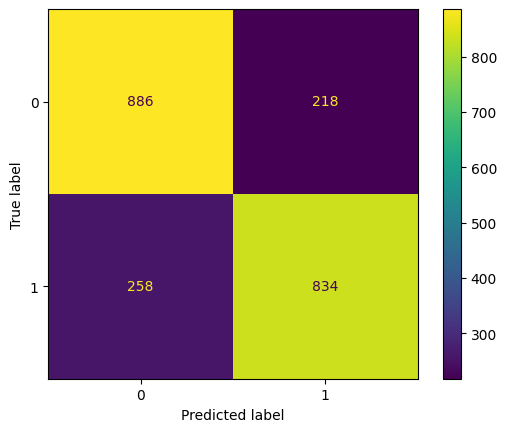

In [962]:
score1, history1 = neural_network([3,1], train_inputs_1, train_labels_1, test_inputs_1, test_labels_1)

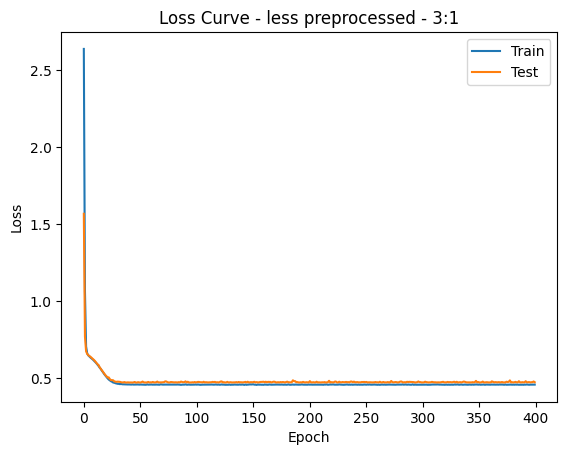

In [963]:
loss_curve(history1, 'Loss Curve - less preprocessed - 3:1')

## 8.4.1 Second Dataset

69/69 [==============================] - 0s 729us/step
Score: 65.0%


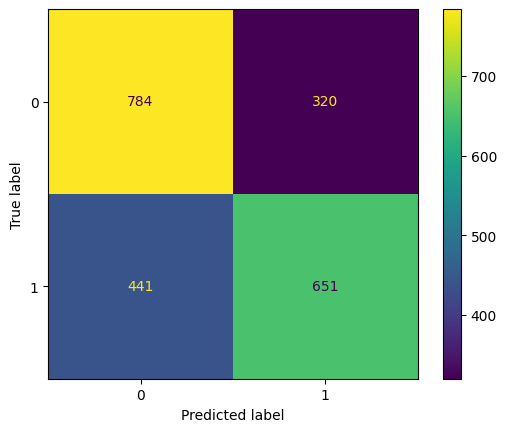

In [964]:
score2, history2 = neural_network([3,1], train_inputs_2, train_labels_2, test_inputs_2, test_labels_2)

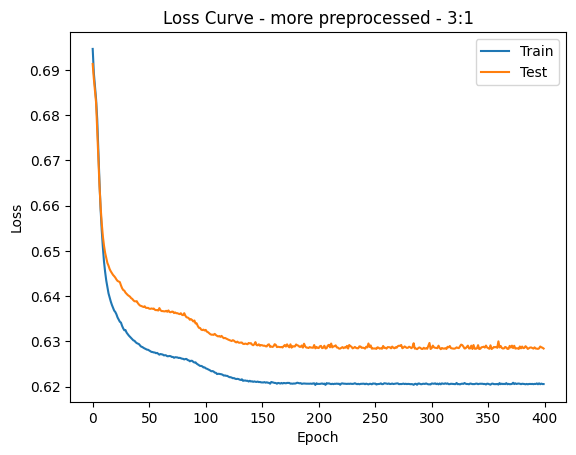

In [965]:
loss_curve(history2, 'Loss Curve - more preprocessed - 3:1')

In [966]:
add_to_summary("Neural Network - 3:1", score1, score2)

## 9. Summary

In [967]:
df_summary

,Classifier,First Dataset,Second Dataset
0,Decision Tree: All nodes,97.95,97.95
1,Decision Tree: 8 nodes,88.52,78.37
2,Naive Bayes,76.64,58.20
3,3 Nearest Neighbours,97.86,97.40
4,10 Nearest Neighbours,93.03,92.67
5,25 Nearest Neighbours,80.83,80.83
6,Neural Network - 6:3:1,50.00,65.00
7,Neural Network - 9:6:3:1,82.00,50.00
8,Neural Network - 12:9:6:3:1,84.00,69.00
9,Neural Network - 3:1,78.00,65.00


Looking at the summary table, it can be deduced that for this dataset the best results are given by the classification algorithms : "k Nearest Neighbors", "Binary Tree" and a less powerful neural network. Classification results according to the neural network for more processed data have only 65% correctness. This is less compared to kNN or Binary Tree. 

## Bibliography

- Database: <https://www.kaggle.com/datasets/yasserh/titanic-dataset> <https://www.kaggle.com/c/titanic/data>
- Pandas: <https://pandas.pydata.org/docs/>